#### `Installing and Importing Required Libraries` 

In [63]:
# Understanding how to index JSON file into Azure Search from Blob Storage
# See: https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/search/azure-search-documents/samples/sample_indexer_datasource_skillset.py
import asyncio
import glob
import os
from abc import ABC
from typing import Awaitable, Callable

import nest_asyncio
import tiktoken
from azure.core.credentials import AzureKeyCredential
from azure.core.credentials_async import AsyncTokenCredential
from azure.core.exceptions import ResourceExistsError
from azure.identity.aio import AzureDeveloperCliCredential, get_bearer_token_provider
from azure.search.documents.indexes.aio import SearchIndexClient, SearchIndexerClient
from azure.search.documents.indexes.models import (
    AzureOpenAIEmbeddingSkill,
    AzureOpenAIParameters,
    AzureOpenAIVectorizer,
    HnswAlgorithmConfiguration,
    HnswParameters,
    IndexingParameters,
    IndexingParametersConfiguration,
    IndexProjectionMode,
    InputFieldMappingEntry,
    OutputFieldMappingEntry,
    SearchableField,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SearchIndexer,
    SearchIndexerDataContainer,
    SearchIndexerDataSourceConnection,
    SearchIndexerIndexProjections,
    SearchIndexerIndexProjectionSelector,
    SearchIndexerIndexProjectionsParameters,
    SearchIndexerSkillset,
    SemanticConfiguration,
    SemanticField,
    SemanticPrioritizedFields,
    SemanticSearch,
    SimpleField,
    SplitSkill,
    VectorSearch,
    VectorSearchProfile,
)
from azure.storage.blob.aio import BlobServiceClient
from dotenv import load_dotenv
from openai import AsyncAzureOpenAI, AsyncOpenAI, RateLimitError
from tenacity import (
    AsyncRetrying,
    retry_if_exception_type,
    stop_after_attempt,
    wait_random_exponential,
)
from typing_extensions import TypedDict

from app.backend.prepdocslib.blobmanager import BlobManager
from app.backend.prepdocslib.listfilestrategy import LocalListFileStrategy

# Trial Cloud
# load_dotenv(".azure/hhgai-dev-eastus-002/.env")

# Enterprise Cloud
load_dotenv(".azure/hhgai-prod-eastasia-001/.env")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Key variable values to make sure are the correct name:
1. `container`
2. `file_name`
3. `index_name`

#### `Setting-up Blob Storage` 

##### 1. Create a new container in the Azure Portal

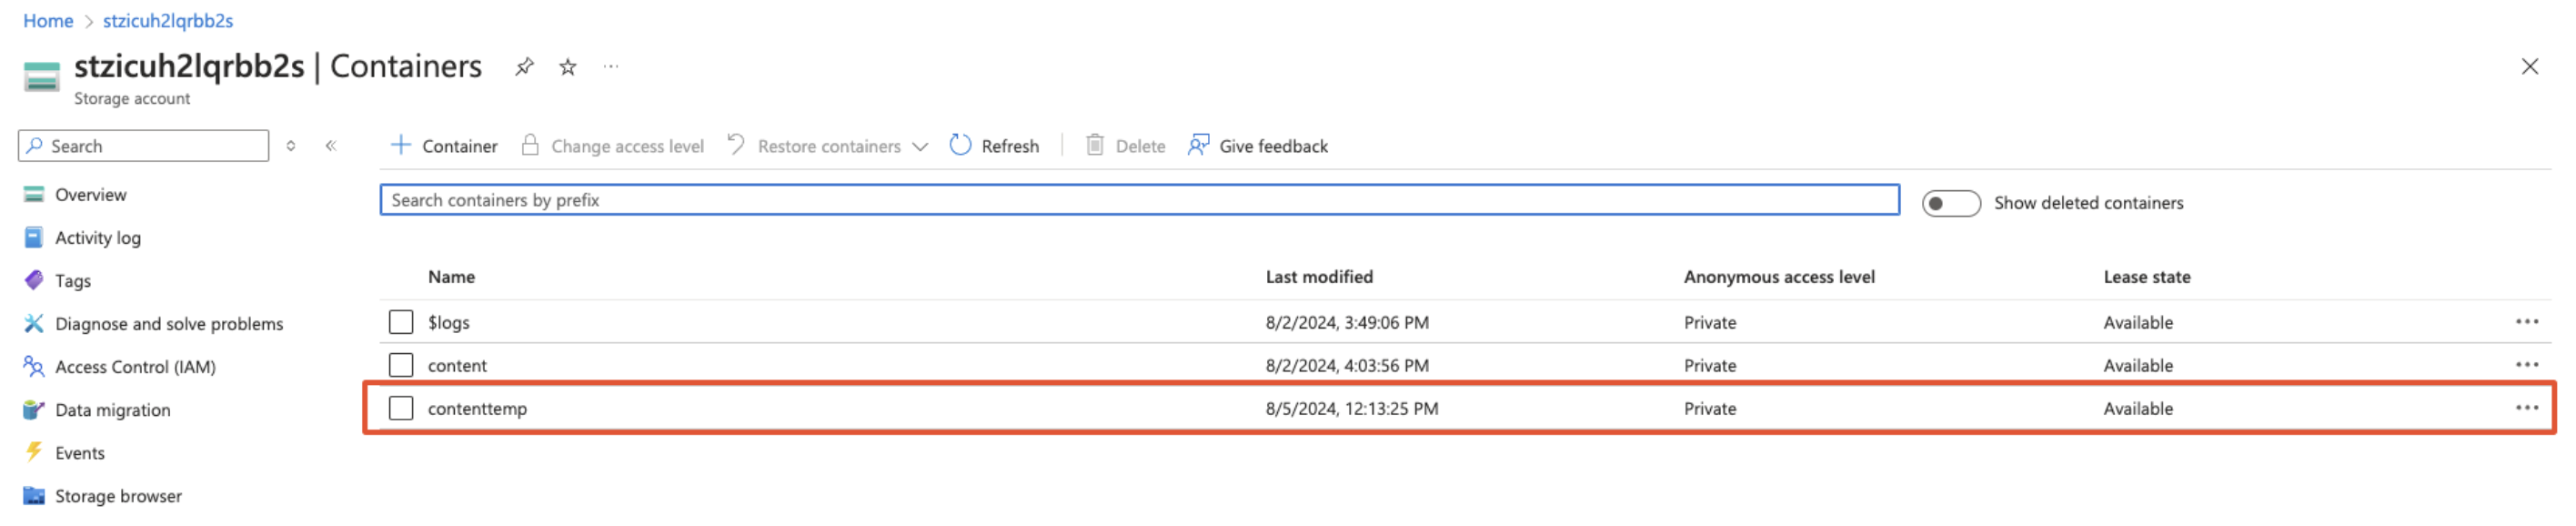




##### 2. Connecting to the container 

In [64]:
storage_account: str = os.getenv("AZURE_STORAGE_ACCOUNT")  # name of storage account
# container: str = os.getenv("AZURE_STORAGE_CONTAINER")  # name of container
container: str = "content"  # please use a temporary container name for testing
tenantid: str | None = os.getenv("AZURE_TENANT_ID")  # None
storage_key: str | None = None  # we're not using keys

# Use the current user identity to connect to Azure services unless a key is explicitly set for any of them
azure_credential = (
    AzureDeveloperCliCredential()
    if tenantid is None
    else AzureDeveloperCliCredential(tenant_id=tenantid, process_timeout=60)
)

storage_creds: AsyncTokenCredential | str = azure_credential if storage_key is None else storage_key

# Blob service client
blob_service = BlobServiceClient(
    account_url=f"https://{storage_account}.blob.core.windows.net", credential=storage_creds
)

##### 2. If there is an existing container, remove the current Blobs in the Blob Storage

Specify an existing file path in the `path` variable or use `None` to remove all files in the container.


In [65]:
# Apply the patch to allow nested event loops
nest_asyncio.apply()


async def remove_blobs(storage_account, storage_creds, container, path=None):
    # Using context manager to get blob service client and container client
    async with BlobServiceClient(
        account_url=f"https://{storage_account}.blob.core.windows.net", credential=storage_creds
    ) as service_client, service_client.get_container_client(container) as container_client:

        # Check if container already exists in Azure Blob Storage
        exists = await container_client.exists()
        print(f"Container exists: {exists}")
        if not exists:
            print("Container doesn't exist. There's nothing to remove.")
        else:
            # If no path is specified, list all blob paths in the container
            if path is None:
                blobs = container_client.list_blob_names()
            else:
                prefix = os.path.splitext(os.path.basename(path))[0]
                blobs = container_client.list_blob_names(name_starts_with=prefix)

            async for blob_path in blobs:
                print(f"Removing blob {blob_path}")
                await container_client.delete_blob(blob_path)


# Define a function to run the async function


def run_remove_blobs(storage_account, storage_creds, container, path=None):
    loop = asyncio.get_event_loop()
    loop.run_until_complete(remove_blobs(storage_account, storage_creds, container, path))


# Call the function in your script or notebook
run_remove_blobs(storage_account, storage_creds, container)

Container exists: True


#### `LocalListFileStrategy` and `File`

#### 1. Delete the md5 hashes in the `data` folder before uploading into the Blob storage

In [66]:
# First remove all md5 hashes to reupload the files
file_name = "/data_processing/processed_articles"  # If encounter error whereby md5 hashes aren't being deleted, change this value to "data_processing/processed_articles"


def remove_md5_hashes(path: str):
    for md5_file in glob.glob(path, recursive=True):
        if os.path.exists(md5_file):
            os.remove(md5_file)
            print(f"Removed {os.path.basename(md5_file)}")


remove_md5_hashes(os.path.join(f"{file_name}", "*.md5"))

#### 2. List down all the files in the folder to be uploaded to the Blob Storage

In [67]:
local_files = f"./{file_name}/*"
list_file_strategy = LocalListFileStrategy(path_pattern=local_files)

# Prints out all paths
async for p in list_file_strategy.list_paths():
    print(p)

.//data_processing/processed_articles\1434574_content.json
.//data_processing/processed_articles\1434574_table.json
.//data_processing/processed_articles\1434585_content.json
.//data_processing/processed_articles\1434588_content.json
.//data_processing/processed_articles\1434592_content.json
.//data_processing/processed_articles\1434596_content.json
.//data_processing/processed_articles\1434596_table.json
.//data_processing/processed_articles\1434598_content.json
.//data_processing/processed_articles\1434600_content.json
.//data_processing/processed_articles\1434610_content.json
.//data_processing/processed_articles\1434610_content_js.json
.//data_processing/processed_articles\1434612_content.json
.//data_processing/processed_articles\1434612_table.json
.//data_processing/processed_articles\1434614_content.json
.//data_processing/processed_articles\1434616_content.json
.//data_processing/processed_articles\1434628_content.json
.//data_processing/processed_articles\1434636_content.json


#### 3. Upload to Blob Storage

In [68]:
# Takes ~30mins to run

# Apply the patch to allow nested event loops (useful for Jupyter notebooks)
nest_asyncio.apply()


async def upload_blobs(storage_account, storage_creds, container, list_file_strategy):
    # Using context manager to get blob service client and container client
    async with BlobServiceClient(
        account_url=f"https://{storage_account}.blob.core.windows.net",
        credential=storage_creds,
        max_single_put_size=4 * 1024 * 1024,
    ) as service_client, service_client.get_container_client(container) as container_client:

        # Check if the container already exists in Azure Blob Storage
        exists = await container_client.exists()
        print(f"Container exists: {exists}")
        if not exists:
            print(f"Container doesn't exist. Creating container {container}.")
            await container_client.create_container()

        # List all the local files and upload them
        async for file in list_file_strategy.list():
            if file.url is None:
                with open(file.content.name, "rb") as reopened_file:
                    # Get the basename of the file
                    blob_name = BlobManager.blob_name_from_file_name(file.content.name)
                    print(f"Uploading blob for whole file -> {blob_name}")
                    blob_client = await container_client.upload_blob(blob_name, reopened_file, overwrite=True)
                    file.url = blob_client.url


# Define a function to run the async function


def run_upload_blobs(storage_account, storage_creds, container, list_file_strategy):
    loop = asyncio.get_event_loop()
    loop.run_until_complete(upload_blobs(storage_account, storage_creds, container, list_file_strategy))


# To call the function in your script or notebook
run_upload_blobs(storage_account, storage_creds, container, list_file_strategy)

Container exists: True
Uploading blob for whole file -> 1434574_content.json
Uploading blob for whole file -> 1434574_table.json
Uploading blob for whole file -> 1434585_content.json
Uploading blob for whole file -> 1434588_content.json
Uploading blob for whole file -> 1434592_content.json
Uploading blob for whole file -> 1434596_content.json
Uploading blob for whole file -> 1434596_table.json
Uploading blob for whole file -> 1434598_content.json
Uploading blob for whole file -> 1434600_content.json
Uploading blob for whole file -> 1434610_content.json
Uploading blob for whole file -> 1434610_content_js.json
Uploading blob for whole file -> 1434612_content.json
Uploading blob for whole file -> 1434612_table.json
Uploading blob for whole file -> 1434614_content.json
Uploading blob for whole file -> 1434616_content.json
Uploading blob for whole file -> 1434628_content.json
Uploading blob for whole file -> 1434636_content.json
Uploading blob for whole file -> 1434642_content.json
Uploadin

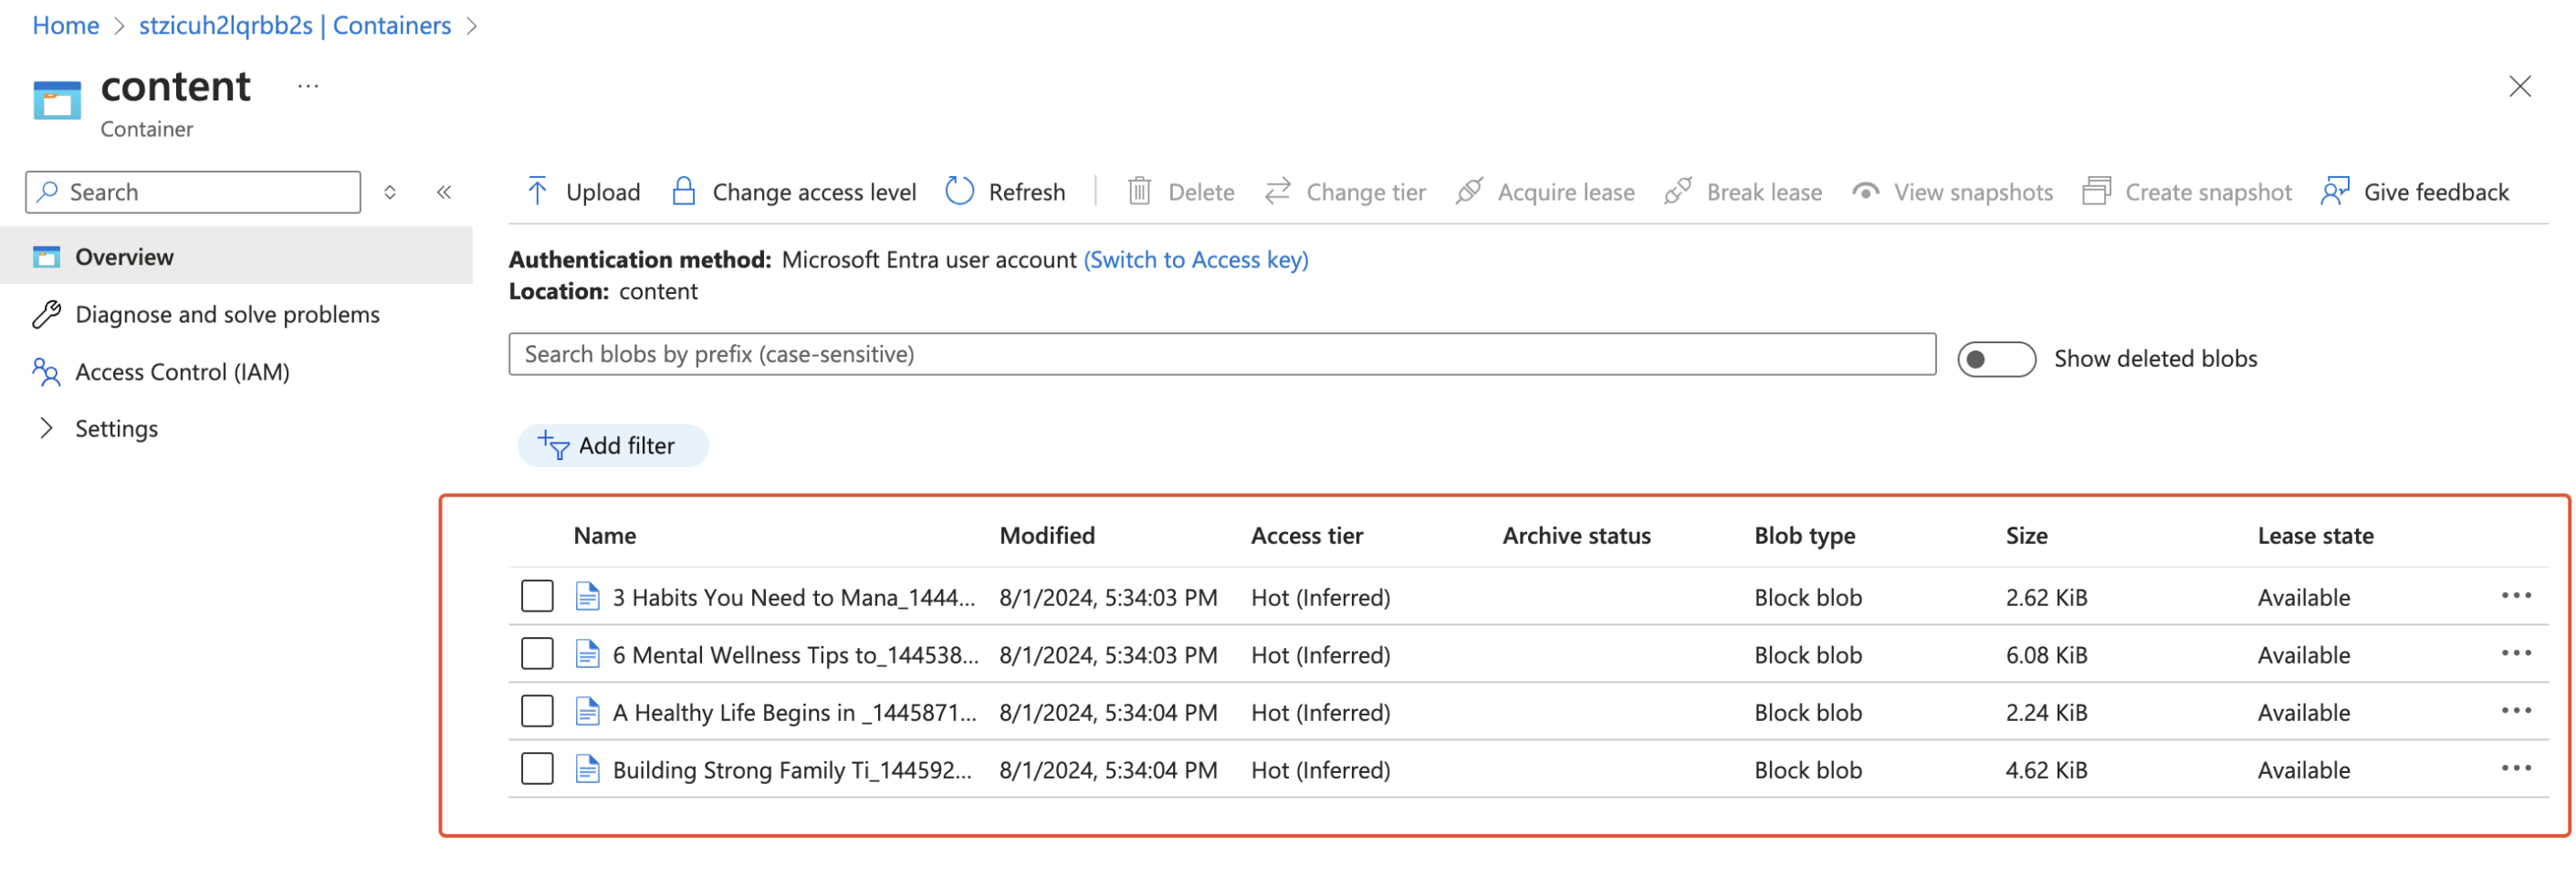

#### `Azure OpenAI Service`


We are going to create `Class` for this service. You may ignore the code below for now. In summary, we will create a parent class that will be inherited from by `AzureOpenAIEmbeddingService`.

#### 1. The classes for OpenAIEmbeddings

In [69]:
class ExtraArgs(TypedDict, total=False):
    dimensions: int


class EmbeddingBatch:
    """
    Represents a batch of text that is going to be embedded
    """

    def __init__(self, texts: list[str], token_length: int):
        self.texts = texts
        self.token_length = token_length


class OpenAIEmbeddings(ABC):
    """
    Contains common logic across both OpenAI and Azure OpenAI embedding services
    Can split source text into batches for more efficient embedding calls
    """

    SUPPORTED_BATCH_AOAI_MODEL = {
        "text-embedding-ada-002": {"token_limit": 8100, "max_batch_size": 16},
        "text-embedding-3-small": {"token_limit": 8100, "max_batch_size": 16},
        "text-embedding-3-large": {"token_limit": 8100, "max_batch_size": 16},
    }

    # See: https://platform.openai.com/docs/guides/embeddings/what-are-embeddings#:~:text=By%20default%2C%20the,case%20section.
    SUPPORTED_DIMENSIONS_MODEL = {
        "text-embedding-ada-002": False,
        "text-embedding-3-small": True,
        "text-embedding-3-large": True,
    }

    def __init__(self, open_ai_model_name: str, open_ai_dimensions: int, disable_batch: bool = False):
        self.open_ai_model_name = open_ai_model_name
        self.open_ai_dimensions = open_ai_dimensions
        self.disable_batch = disable_batch

    async def create_client(self) -> AsyncOpenAI:
        raise NotImplementedError

    def before_retry_sleep(self, retry_state):
        print("Rate limited on the OpenAI embeddings API, sleeping before retrying...")

    def calculate_token_length(self, text: str) -> int:
        encoding = tiktoken.encoding_for_model(self.open_ai_model_name)
        return len(encoding.encode(text))

    def split_text_into_batches(self, texts: list[str]) -> list[EmbeddingBatch]:
        batch_info = OpenAIEmbeddings.SUPPORTED_BATCH_AOAI_MODEL.get(self.open_ai_model_name)
        if not batch_info:
            raise NotImplementedError(
                f"Model {self.open_ai_model_name} is not supported with batch embedding operations"
            )

        batch_token_limit = batch_info["token_limit"]
        batch_max_size = batch_info["max_batch_size"]
        batches: list[EmbeddingBatch] = []
        batch: list[str] = []
        batch_token_length = 0
        for text in texts:
            text_token_length = self.calculate_token_length(text)
            # If the batch_token_length + text_token_length exceeds or is equal to the batch_token_limit
            # and the batch is not empty, add the batch to the list of batches
            if batch_token_length + text_token_length >= batch_token_limit and len(batch) > 0:
                batches.append(EmbeddingBatch(batch, batch_token_length))
                # Reset
                batch = []
                batch_token_length = 0

            batch.append(text)
            batch_token_length += text_token_length
            # If the batch is equal to the batch_max_size, add the batch to the list of batches
            if len(batch) == batch_max_size:
                batches.append(EmbeddingBatch(batch, batch_token_length))
                # Reset
                batch = []
                batch_token_length = 0

        # At the end, check if there are any remaining elements in the batch
        if len(batch) > 0:
            batches.append(EmbeddingBatch(batch, batch_token_length))

        return batches

    async def create_embedding_batch(self, texts: list[str], dimensions_args: ExtraArgs) -> list[list[float]]:
        batches = self.split_text_into_batches(texts)
        embeddings = []
        client = await self.create_client()
        for batch in batches:
            async for attempt in AsyncRetrying(
                retry=retry_if_exception_type(RateLimitError),
                wait=wait_random_exponential(min=15, max=60),
                stop=stop_after_attempt(15),
                before_sleep=self.before_retry_sleep,
            ):
                with attempt:
                    emb_response = await client.embeddings.create(
                        model=self.open_ai_model_name, input=batch.texts, **dimensions_args
                    )
                    embeddings.append([data.embdding for data in emb_response.data])
                    print(
                        "Computed embeddings in batch. Batch size: %d, Token count: %d",
                        len(batch.texts),
                        batch.token_length,
                    )

        return embeddings

    async def create_embedding_single(self, text: str, dimensions_args: ExtraArgs) -> list[float]:
        client = await self.create_client()
        async for attempt in AsyncRetrying(
            retry=retry_if_exception_type(RateLimitError),
            wait=wait_random_exponential(min=15, max=60),
            stop=stop_after_attempt(15),
            before_sleep=self.before_retry_sleep,
        ):
            with attempt:
                emb_response = await client.embeddings.create(
                    model=self.open_ai_model_name, input=text, **dimensions_args
                )
                print("Computed embedding for text section. Character count: %d", len(text))

        return emb_response.data[0].embedding

    async def create_embeddings(self, texts: list[str]) -> list[list[float]]:
        # Only supported in text-embedding-3 and later models.
        dimensions_args: ExtraArgs = (
            {"dimensions": self.open_ai_dimensions}
            if OpenAIEmbeddings.SUPPORTED_DIMENSIONS_MODEL.get(self.open_ai_model_name)
            else {}
        )

        if not self.disable_batch and self.open_ai_model_name in OpenAIEmbeddings.SUPPORTED_BATCH_AOAI_MODEL:
            return await self.create_embedding_batch(texts, dimensions_args)

        return [await self.create_embedding_single(text, dimensions_args) for text in texts]

Now, for the main class for embedding services. It simply implements the `create_client` method which creates the `AsyncAzureOpenAI` Class and inherits the other methods from the parent class above.

#### 2. The classes for AzureOpenAIEmbeddingService

In [70]:
class AzureOpenAIEmbeddingService(OpenAIEmbeddings):
    """
    Class for using Azure OpenAI embeddings
    To learn more please visit https://learn.microsoft.com/azure/ai-services/openai/concepts/understand-embeddings
    """

    def __init__(
        self,
        open_ai_service: str | None,
        open_ai_deployment: str | None,
        open_ai_model_name: str,
        open_ai_dimensions: int,
        credential: AsyncTokenCredential | AzureKeyCredential,
        open_ai_custom_url: str | None = None,
        disable_batch: bool = False,
    ):
        super().__init__(open_ai_model_name, open_ai_dimensions, disable_batch)
        self.open_ai_service = open_ai_service
        if open_ai_service:
            self.open_ai_endpoint = f"https://{open_ai_service}.openai.azure.com"
        elif open_ai_custom_url:
            self.open_ai_endpoint = open_ai_custom_url
        else:
            raise ValueError("Either open_ai_service or open_ai_custom_url must be provided")
        self.open_ai_deployment = open_ai_deployment
        self.credential = credential

    async def create_client(self) -> AsyncOpenAI:
        # Specify a Class to hold the authentication parameters
        class AuthArgs(TypedDict, total=False):
            api_key: str
            azure_ad_token_provider: Callable[[], str | Awaitable[str]]

        # Check if API Key was used or Azure AD
        auth_args = AuthArgs()
        # If API Key was used, assign it to AuthArgs
        if isinstance(self.credential, AzureKeyCredential):
            auth_args["api_key"] = self.credential.key
        elif isinstance(self.credential, AsyncTokenCredential):
            auth_args["azure_ad_token_provider"] = get_bearer_token_provider(
                self.credential, "https://cognitiveservices.azure.com/.default"
            )
        else:
            raise TypeError("Invalid credential type")

        return AsyncAzureOpenAI(
            azure_endpoint=self.open_ai_endpoint,
            azure_deployment=self.open_ai_deployment,
            api_version="2023-05-15",
            **auth_args,
        )

#### 3. Creating the embedding service

In [71]:
open_ai_service: str = os.getenv("AZURE_OPENAI_SERVICE")  # name of search service
open_ai_deployment: str = os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT")  # name of deployment
open_ai_model_name: str = os.getenv("AZURE_OPENAI_EMB_MODEL_NAME")  # name of the embedding model
open_ai_dimensions: int = 1536  # dimensionality of the embeddings
disable_batch_vectors: bool = False
openai_key: str | None = None  # we're not using keys

# Use the current user identity to connect to Azure services unless a key is explicitly set for any of them
azure_credential = (
    AzureDeveloperCliCredential()
    if tenantid is None
    else AzureDeveloperCliCredential(tenant_id=tenantid, process_timeout=60)
)

azure_open_ai_credential: AsyncTokenCredential | AzureKeyCredential = (
    azure_credential if openai_key is None else AzureKeyCredential(openai_key)
)

embeddings = AzureOpenAIEmbeddingService(
    open_ai_service=open_ai_service,
    open_ai_custom_url=None,
    open_ai_deployment=open_ai_deployment,
    open_ai_model_name=open_ai_model_name,
    open_ai_dimensions=open_ai_dimensions,
    credential=azure_open_ai_credential,
    disable_batch=disable_batch_vectors,
)

#### 4. Running the embedding

**Note:** Please only run the following cell when needed — it costs money.

In [72]:
# single_embedding = await embeddings.create_embedding_single("hello world", dimensions_args)
# len(single_embedding)

#### `Azure AI Search`


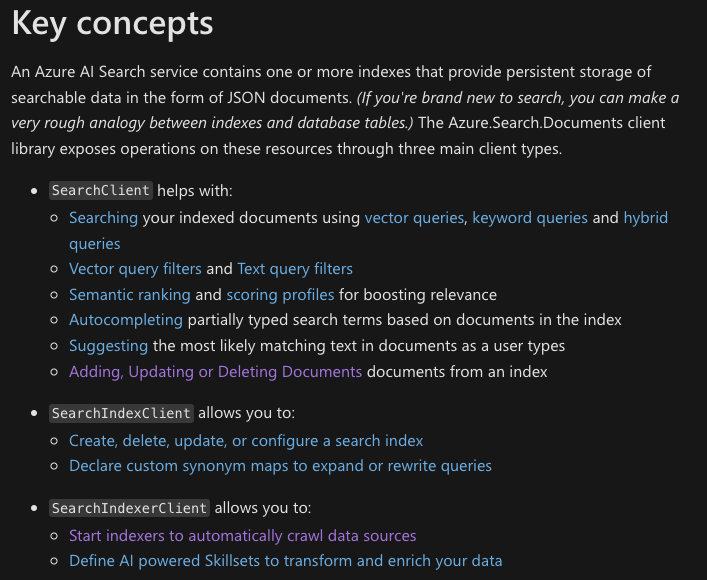

- `SearchClient`: for searching indexed documents.

- `SearchIndexClient`: for managing indexes.

- `SearchIndexerClient`: for crawling data sources and loading search documents into an index.

**Note:** https://learn.microsoft.com/en-us/python/api/overview/azure/search-documents-readme?view=azure-python

#### 1. Extracting the credentials for the Azure AI Search

In [73]:
# Enhancing SearchClient
# See: https://learn.microsoft.com/en-us/training/modules/create-azure-cognitive-search-solution/7-enhance-index

search_service = os.getenv("AZURE_SEARCH_SERVICE")  # name of search service
# index = os.getenv("AZURE_SEARCH_INDEX")  # name of index
index_name = "gptkbindex"  # please use a temporary index name for testing
tenantid: str | None = os.getenv("AZURE_TENANT_ID")  # None
search_key = None  # we're not using keys

# Use the current user identity to connect to Azure services unless a key is explicitly set for any of them
azure_credential = (
    AzureDeveloperCliCredential()
    if tenantid is None
    else AzureDeveloperCliCredential(tenant_id=tenantid, process_timeout=60)
)

search_creds: AsyncTokenCredential | str = azure_credential if search_key is None else search_key

#### Common way to instantiate the clients:

SearchClient
```python
search_client = SearchClient(
    endpoint=f"https://{search_service}.search.windows.net/", index_name=index, credential=search_creds
)
```
SearchIndexClient
```python
search_index_client = SearchIndexClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
)
```
SearchIndexerClient
```python
search_indexer_client = SearchIndexerClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
)
```

**Note:** However, we will be using the asynchronous context managers (see below) to instantiate the clients instead.


#### `SearchClient`


#### 1. Specify the fields for the search client


Before we create an index, we first have to specify the fields with its parameters in the index.

- **searchable:** Allows full-text search on the field.

- **filterable:** Allows filtering based on exact matches or ranges.

- **sortable:** Allows sorting of search results.

- **facetable**: Allows the creation of facets for refining search results.

In [74]:
# See: https://learn.microsoft.com/en-us/azure/search/vector-search-integrated-vectorization
# Integrated Vectorization
use_int_vectorization: bool = True
analyzer_name: str | None = "en.microsoft"

fields = []

if use_int_vectorization:
    fields.append(SearchableField(name="parent_id", type=SearchFieldDataType.String, filterable=True))
    fields.append(
        SearchField(
            name="id",
            type=SearchFieldDataType.String,
            key=True,
            sortable=True,
            filterable=True,
            facetable=True,
            analyzer_name="keyword",
        )
    )
else:
    fields.append(SimpleField(name="id", type=SearchFieldDataType.String, key=True))

fields.extend(
    [
        SearchableField(
            name="title",
            type=SearchFieldDataType.String,
            analyzer_name="en.lucene" if analyzer_name is None else analyzer_name,
        ),
        SimpleField(name="cover_image_url", type=SearchFieldDataType.String),
        SimpleField(name="full_url", type=SearchFieldDataType.String),
        SearchableField(
            name="content_category",
            type=SearchFieldDataType.String,
            analyzer_name="en.lucene" if analyzer_name is None else analyzer_name,
            filterable=True,
        ),
        SearchableField(
            name="category_description",
            type=SearchFieldDataType.String,
            analyzer_name="en.lucene" if analyzer_name is None else analyzer_name,
        ),
        SimpleField(name="pr_name", type=SearchFieldDataType.String),
        SimpleField(name="date_modified", type=SearchFieldDataType.String),
        # SearchableField(
        #     name="content",
        #     type=SearchFieldDataType.String,
        #     analyzer_name="en.lucene" if analyzer_name is None else analyzer_name
        #     ),
        SearchableField(
            name="chunks",
            type=SearchFieldDataType.String,
            analyzer_name="en.lucene" if analyzer_name is None else analyzer_name,
        ),
        SearchField(
            name="embedding",
            type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
            hidden=False,
            searchable=True,
            filterable=False,
            sortable=False,
            facetable=False,
            vector_search_dimensions=embeddings.open_ai_dimensions,
            vector_search_profile_name="embedding_config",
        ),
    ]
)

#### Hybrid Search = Vector Search + Semantic Search

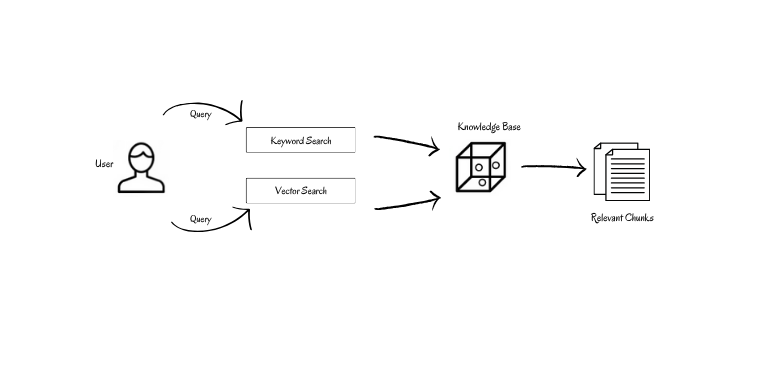

#### 2. Create vector search and semantic search to incorporate into the search index

In [75]:
# See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.searchindex?view=azure-python
index = SearchIndex(
    name=index_name,
    fields=fields,
    semantic_search=SemanticSearch(
        configurations=[
            SemanticConfiguration(
                name="default",
                prioritized_fields=SemanticPrioritizedFields(
                    title_field=SemanticField(field_name="title"),
                    content_fields=[
                        SemanticField(field_name="chunks"),
                    ],  # This is where the caption is, can create a new metadata field for this. The order of the field indicates the priority of the search.
                ),
            )
        ]
    ),
    vector_search=VectorSearch(
        # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.vectorsearchalgorithmconfiguration?view=azure-python
        # Algorithm used for vector search
        algorithms=[HnswAlgorithmConfiguration(name="hnsw_config", parameters=HnswParameters(metric="cosine"))],
        # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.vectorsearchprofile?view=azure-python
        # Specify the profiles for the vector search and computing the embeddings
        profiles=[
            VectorSearchProfile(
                name="embedding_config",
                algorithm_configuration_name="hnsw_config",
                vectorizer=(f"{index_name}-vectorizer" if use_int_vectorization else None),
            ),
        ],
        # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.vectorsearchvectorizer?view=azure-python
        # See: https://learn.microsoft.com/en-us/azure/search/vector-search-vectorizer-azure-open-ai
        vectorizers=[
            AzureOpenAIVectorizer(
                name=f"{index_name}-vectorizer",
                kind="azureOpenAI",
                azure_open_ai_parameters=AzureOpenAIParameters(
                    resource_uri=f"https://{embeddings.open_ai_service}.openai.azure.com",
                    deployment_id=embeddings.open_ai_deployment,
                ),
            )
        ],
    ),
)

#### `SearchIndexClient`


#### 1. List the existing index

In [76]:
async with SearchIndexClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
) as search_index_client:
    index_names = [name async for name in search_index_client.list_index_names()]
    print(index_names)

[]


#### 2. Remove the index if it exists

In [77]:
# Apply the patch to allow nested event loops (useful for Jupyter notebooks)
nest_asyncio.apply()


async def manage_search_index(search_service, search_creds, index_name):
    async with SearchIndexClient(
        endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
    ) as search_index_client:
        # Check if the index exists
        if index_name in [name async for name in search_index_client.list_index_names()]:
            print(f"Deleting {index_name} search index")
            await search_index_client.delete_index(index_name)
        else:
            print(f"Search index {index_name} does not exist")


# Define a function to run the async function


def run_manage_search_index(search_service, search_creds, index_name):
    loop = asyncio.get_event_loop()
    loop.run_until_complete(manage_search_index(search_service, search_creds, index_name))


# To call the function in your script or notebook
run_manage_search_index(search_service, search_creds, index_name)

Search index gptkbindex does not exist


#### 3. Create the index

In [78]:
# Apply the patch to allow nested event loops (useful for Jupyter notebooks)
nest_asyncio.apply()


async def manage_or_create_index(search_service, search_creds, index_name, index):
    async with SearchIndexClient(
        endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
    ) as search_index_client:
        # Check if the index already exists
        if index_name not in [name async for name in search_index_client.list_index_names()]:
            # Index does not exist, create it
            print(f"Creating {index_name} search index")
            await search_index_client.create_index(index)
        else:
            # Index exists, update it
            print(f"Search index {index_name} already exists")
            index_definition = await search_index_client.get_index(index_name)
            await search_index_client.create_or_update_index(index_definition)


# Define a function to run the async function


def run_manage_or_create_index(search_service, search_creds, index_name, index):
    loop = asyncio.get_event_loop()
    loop.run_until_complete(manage_or_create_index(search_service, search_creds, index_name, index))


# To call the function in your script or notebook
run_manage_or_create_index(search_service, search_creds, index_name, index)

Creating gptkbindex search index


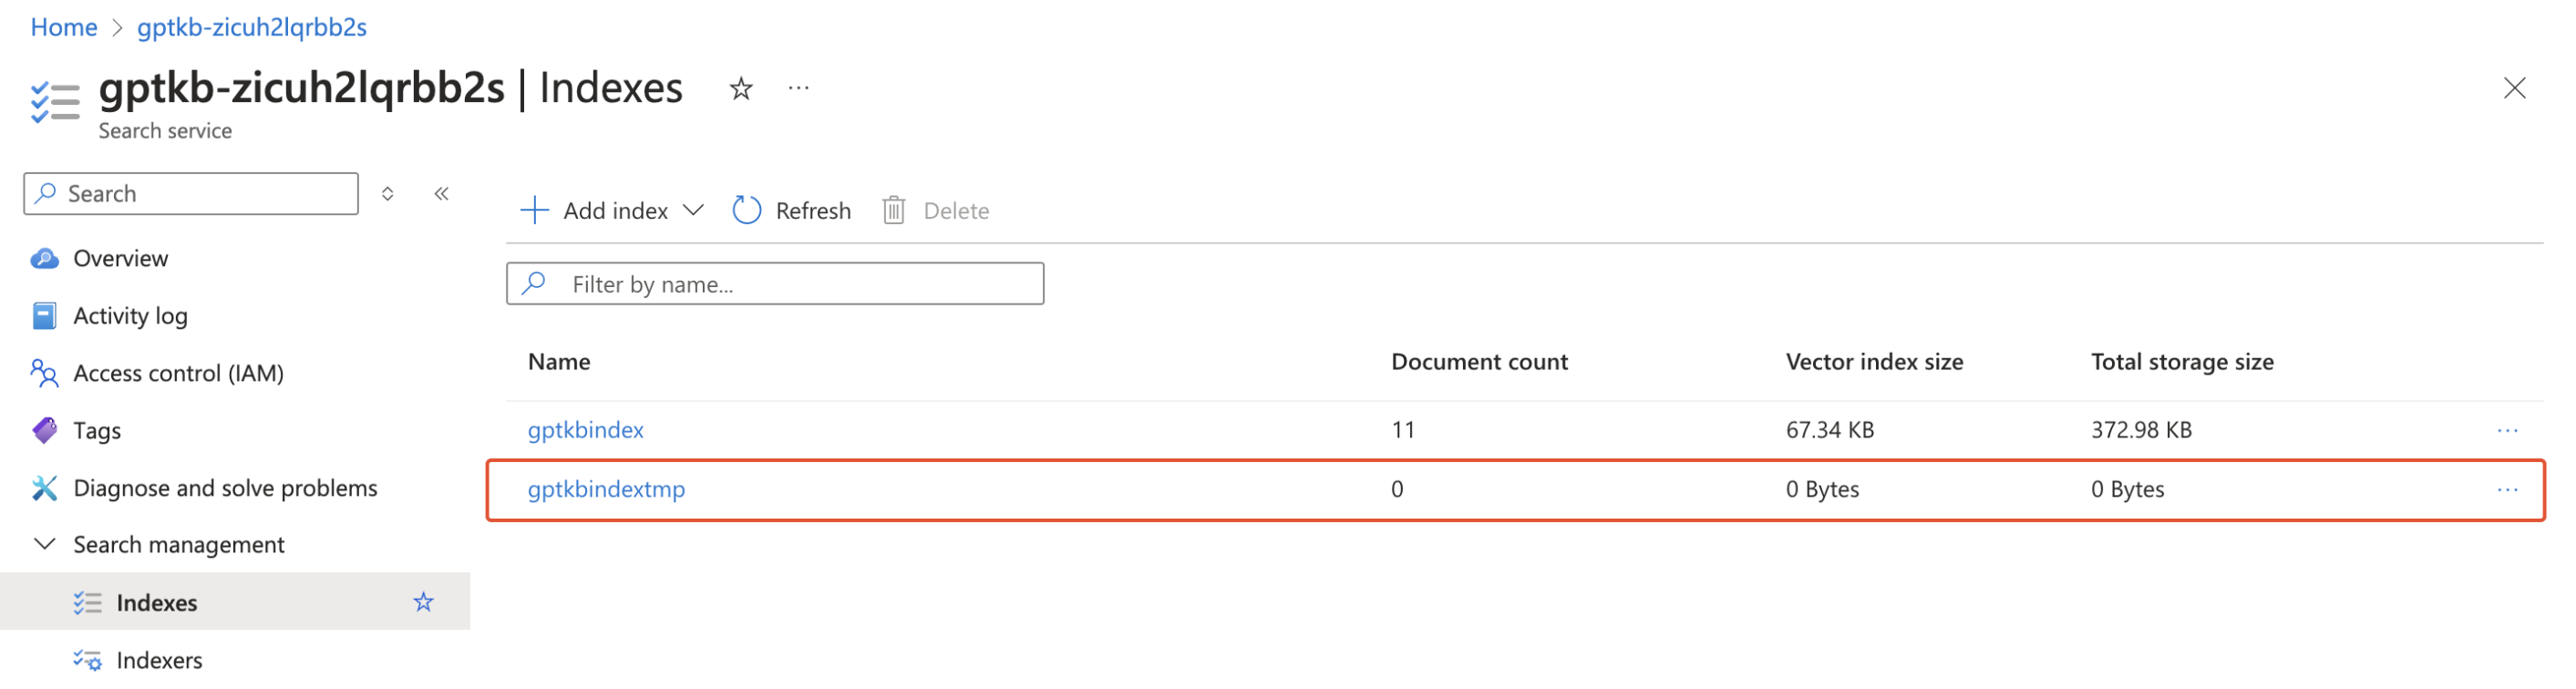

#### 4. Check the schema of the index

In [79]:
# Apply the patch to allow nested event loops (useful for Jupyter notebooks)
nest_asyncio.apply()


async def print_index_fields(search_service, search_creds, index_name):
    async with SearchIndexClient(
        endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
    ) as search_index_client:
        # Get the index
        index = await search_index_client.get_index(index_name)

        # Print details of each field in the index
        for field in index.fields:
            print(field)


# Define a function to run the async function


def run_print_index_fields(search_service, search_creds, index_name):
    loop = asyncio.get_event_loop()
    loop.run_until_complete(print_index_fields(search_service, search_creds, index_name))


# To call the function in your script or notebook
run_print_index_fields(search_service, search_creds, index_name)

{'additional_properties': {}, 'name': 'parent_id', 'type': 'Edm.String', 'key': False, 'hidden': False, 'searchable': True, 'filterable': True, 'sortable': False, 'facetable': False, 'analyzer_name': None, 'search_analyzer_name': None, 'index_analyzer_name': None, 'normalizer_name': None, 'synonym_map_names': [], 'fields': None, 'vector_search_dimensions': None, 'vector_search_profile_name': None}
{'additional_properties': {}, 'name': 'id', 'type': 'Edm.String', 'key': True, 'hidden': False, 'searchable': True, 'filterable': True, 'sortable': True, 'facetable': True, 'analyzer_name': 'keyword', 'search_analyzer_name': None, 'index_analyzer_name': None, 'normalizer_name': None, 'synonym_map_names': [], 'fields': None, 'vector_search_dimensions': None, 'vector_search_profile_name': None}
{'additional_properties': {}, 'name': 'title', 'type': 'Edm.String', 'key': False, 'hidden': False, 'searchable': True, 'filterable': False, 'sortable': False, 'facetable': False, 'analyzer_name': 'en.mi

#### `SearchIndexerClient`


#### 1. Get credentials for the Blob Storage (Data Source)

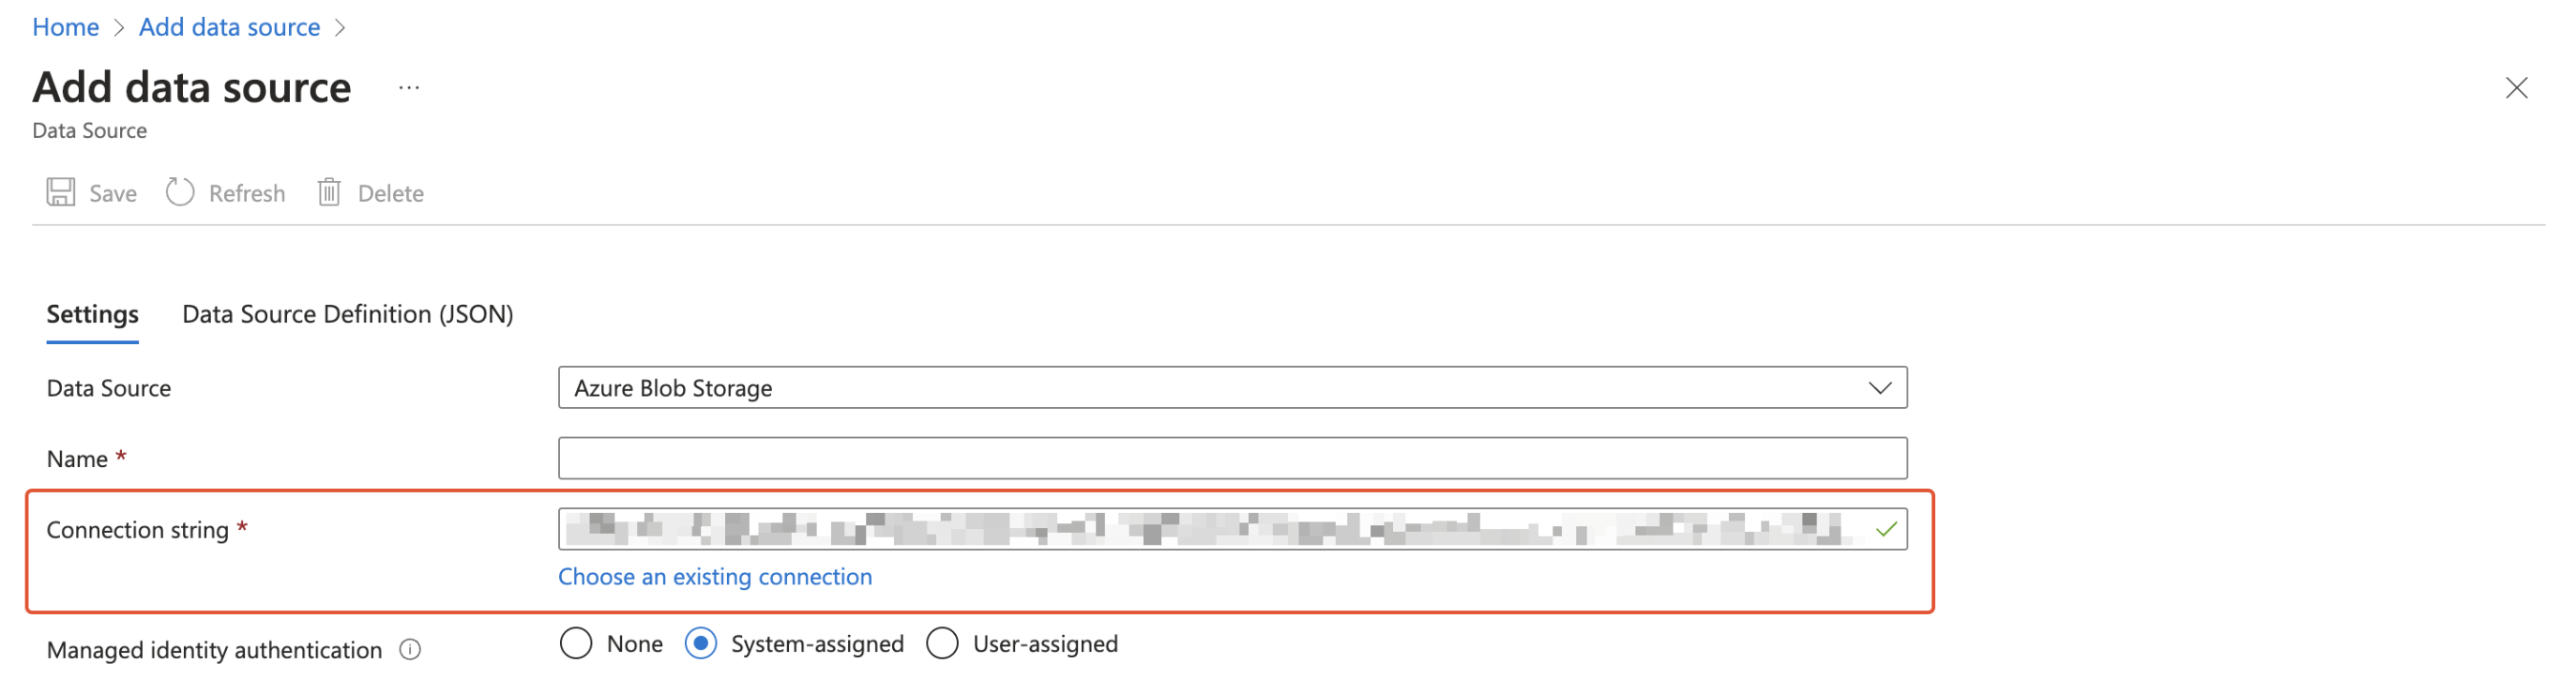

In [80]:
# Hierarchy of the index structure
# See: https://learn.microsoft.com/en-us/training/modules/create-azure-cognitive-search-solution/4-indexing-process


# See: https://learn.microsoft.com/en-us/rest/api/searchservice/
def get_managed_identity_connection_string() -> str:
    """Get managed identity connection string for storage account"""
    return f"ResourceId=/subscriptions/{os.getenv('AZURE_SUBSCRIPTION_ID')}/resourceGroups/{os.getenv('AZURE_RESOURCE_GROUP')}/providers/Microsoft.Storage/storageAccounts/{os.getenv('AZURE_STORAGE_ACCOUNT')};"

#### 2. Create Skillset

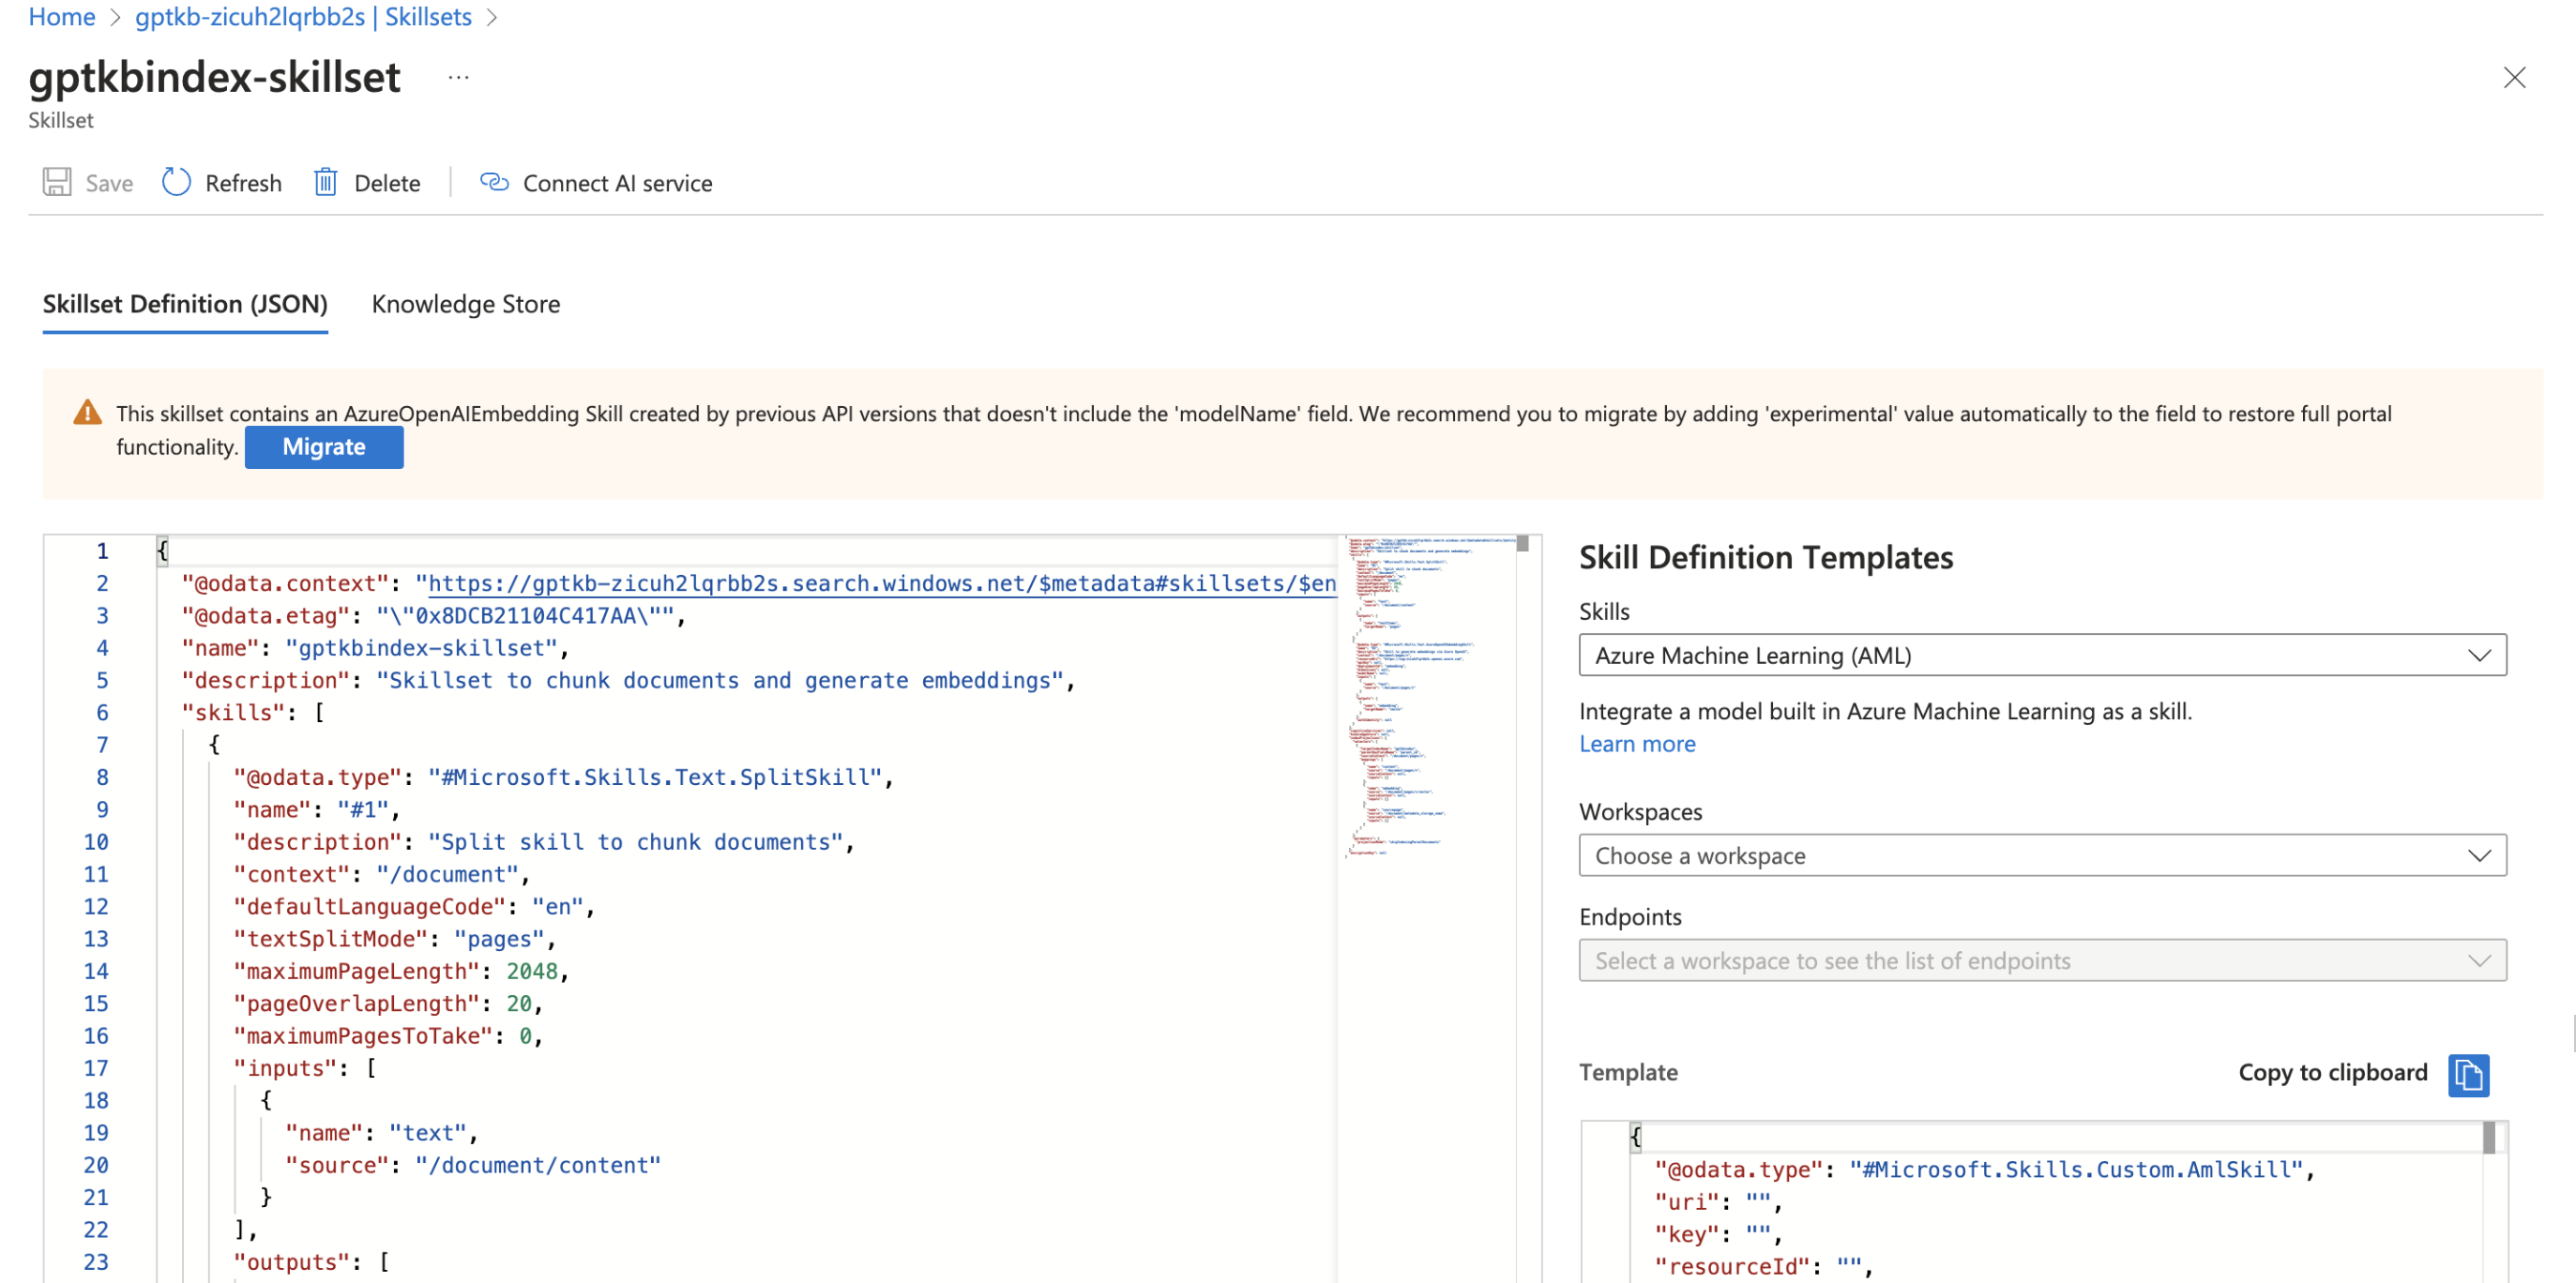

#### Document structure of the JSON file ingested:
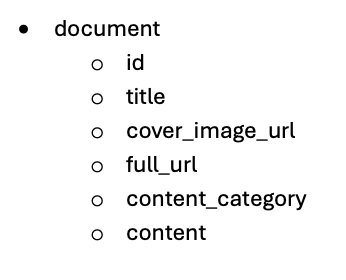

#### After SplitSkill:
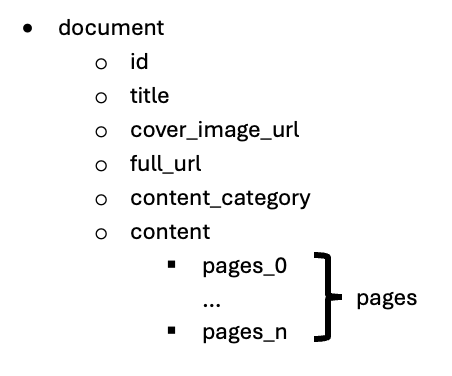

#### After Embedding:
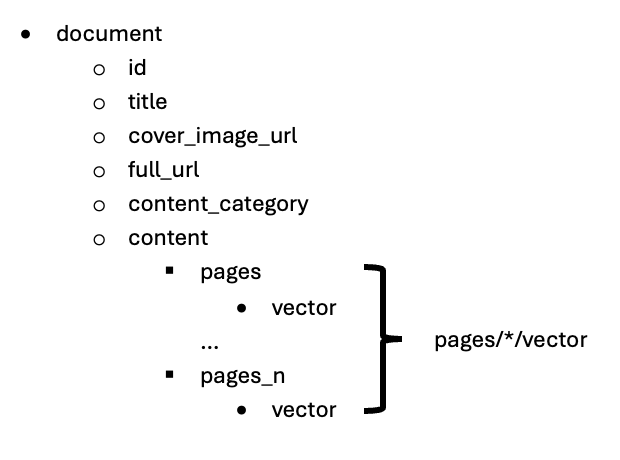

In [81]:
# See: https://learn.microsoft.com/en-us/azure/search/knowledge-store-create-rest
# Helpful to read on the different skills and how they input and output works


async def create_embedding_skill(index_name: str) -> tuple[str, SearchIndexerSkillset]:
    skillset_name = f"{index_name}-skillset"

    # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.splitskill?view=azure-python
    split_skill = SplitSkill(
        # See: https://learn.microsoft.com/en-us/azure/search/cognitive-search-skill-textsplit#example-for-chunking-and-vectorization
        description="Split skill to chunk documents",
        # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.textsplitmode?view=azure-python
        text_split_mode="pages",  # or sentences
        context="/document/content",  # the path to the field to split
        maximum_page_length=5000,
        page_overlap_length=200,  # number of characters/tokens
        # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.inputfieldmappingentry?view=azure-python
        # InputFieldMapping
        inputs=[InputFieldMappingEntry(name="text", source="/document/content")],
        # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.outputfieldmappingentry?view=azure-python
        # OutputFieldMapping
        outputs=[OutputFieldMappingEntry(name="textItems", target_name="pages")],
    )

    if embeddings is None:
        raise ValueError("Expecting Azure Open AI instance")

    embedding_skill = AzureOpenAIEmbeddingSkill(
        description="Skill to generate embeddings via Azure OpenAI",
        context="/document/content/pages/*",
        resource_uri=f"https://{embeddings.open_ai_service}.openai.azure.com",
        deployment_id=embeddings.open_ai_deployment,
        inputs=[InputFieldMappingEntry(name="text", source="/document/content/pages/*")],
        outputs=[OutputFieldMappingEntry(name="embedding", target_name="vector")],
    )

    index_projections = SearchIndexerIndexProjections(
        selectors=[
            SearchIndexerIndexProjectionSelector(
                target_index_name=index_name,
                parent_key_field_name="parent_id",
                source_context="/document/content/pages/*",
                mappings=[
                    # Maps the outputs from the indexer to the fields in the index (this is where the data is populated in the index, you must have a field in the index for it to match, the "name" is the name of the input field in the index)
                    # InputFieldMappingEntry(name="id", source="/document/id"), # the parent_id field in the index which is needed for the indexing process will prevent this field from being mapped
                    InputFieldMappingEntry(name="title", source="/document/title"),
                    InputFieldMappingEntry(name="cover_image_url", source="/document/cover_image_url"),
                    InputFieldMappingEntry(name="full_url", source="/document/full_url"),
                    InputFieldMappingEntry(name="content_category", source="/document/content_category"),
                    InputFieldMappingEntry(name="category_description", source="/document/category_description"),
                    InputFieldMappingEntry(name="pr_name", source="/document/pr_name"),
                    InputFieldMappingEntry(name="date_modified", source="/document/date_modified"),
                    # InputFieldMappingEntry(name="content", source="/document/content"), # only the parent document will have this field, we took it out to prevent content overlap in the search
                    InputFieldMappingEntry(name="chunks", source="/document/content/pages/*"),
                    InputFieldMappingEntry(name="embedding", source="/document/content/pages/*/vector"),
                ],
            )
        ],
        parameters=SearchIndexerIndexProjectionsParameters(
            # Source document will be skipped from writing into the indexer's target index
            projection_mode=IndexProjectionMode.SKIP_INDEXING_PARENT_DOCUMENTS  # or INCLUDE_INDEXING_PARENT_DOCUMENTS
        ),
    )

    # See: https://learn.microsoft.com/en-us/python/api/azure-search-documents/azure.search.documents.indexes.models.searchindexerskillset?view=azure-python
    skillset = SearchIndexerSkillset(
        name=skillset_name,
        description="Skillset to chunk documents and generate embeddings",
        skills=[split_skill, embedding_skill],
        index_projections=index_projections,
    )

    return skillset_name, skillset

#### 3. Establish a connection to the Blob Storage (Data Source)

In [82]:
# Apply the patch to allow nested event loops (useful for Jupyter notebooks)
nest_asyncio.apply()


async def update_search_indexer_data_source(search_service, search_creds, index_name, container):
    async with SearchIndexerClient(
        endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
    ) as search_indexer_client:
        ds_container = SearchIndexerDataContainer(name=container)  # the container name in the blob storage
        ds_connection = SearchIndexerDataSourceConnection(
            name=f"{index_name}-blob",
            type="azureblob",
            connection_string=get_managed_identity_connection_string(),
            container=ds_container,
        )

        try:
            await search_indexer_client.create_or_update_data_source_connection(ds_connection)
            print("Search indexer data source connection updated.")
        except ResourceExistsError:
            print("Search indexer data source connection already exists. Nothing to be updated.")

        skillset_name, embedding_skillset = await create_embedding_skill(index_name=index_name)
        await search_indexer_client.create_or_update_skillset(embedding_skillset)
        # No need to explicitly close the client when using a context manager


# Define a function to run the async function


def run_update_search_indexer_data_source(search_service, search_creds, index_name, container):
    loop = asyncio.get_event_loop()
    loop.run_until_complete(update_search_indexer_data_source(search_service, search_creds, index_name, container))


# To call the function in your script or notebook
run_update_search_indexer_data_source(search_service, search_creds, index_name, container)

Search indexer data source connection updated.


#### 4. Create indexer

In [83]:
# Apply the patch to allow nested event loops (useful for Jupyter notebooks)
nest_asyncio.apply()

skillset_name = f"{index_name}-skillset"
indexer_name = f"{index_name}-indexer"


async def create_and_run_indexer(search_service, search_creds, index_name):
    # Define the indexer
    indexer = SearchIndexer(
        name=indexer_name,
        description="Indexer to index documents and generate embeddings",
        skillset_name=skillset_name,
        target_index_name=index_name,
        data_source_name=f"{index_name}-blob",
        parameters=IndexingParameters(
            configuration=IndexingParametersConfiguration(parsing_mode="jsonArray", query_timeout=None)
        ),
    )

    async with SearchIndexerClient(
        endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
    ) as search_indexer_client:
        # Create or update the indexer
        indexer_result = await search_indexer_client.create_or_update_indexer(indexer)
        # Run the indexer
        await search_indexer_client.run_indexer(indexer_name)
        # No need to explicitly close the client when using a context manager

    print(
        f"Successfully created index, indexer: {indexer_result.name}, and skillset. "
        "Please navigate to search service in Azure Portal to view the status of the indexer."
    )


# Define a function to run the async function


def run_create_and_run_indexer(search_service, search_creds, index_name, skillset_name):
    loop = asyncio.get_event_loop()
    loop.run_until_complete(create_and_run_indexer(search_service, search_creds, index_name))


# To call the function in your script or notebook
run_create_and_run_indexer(search_service, search_creds, index_name, skillset_name)

Successfully created index, indexer: gptkbindex-indexer, and skillset. Please navigate to search service in Azure Portal to view the status of the indexer.


#### Content Document:
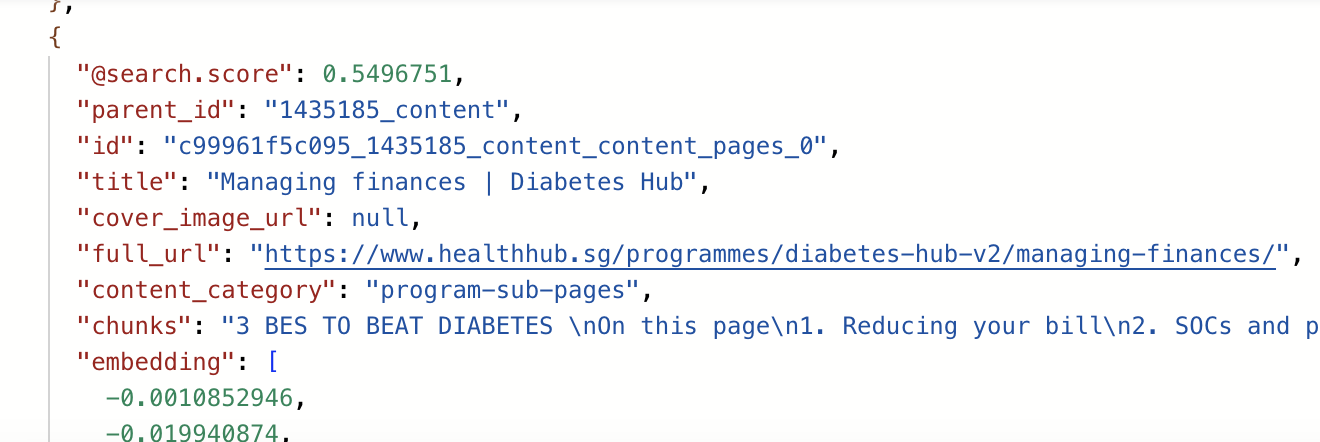

#### Table Document:
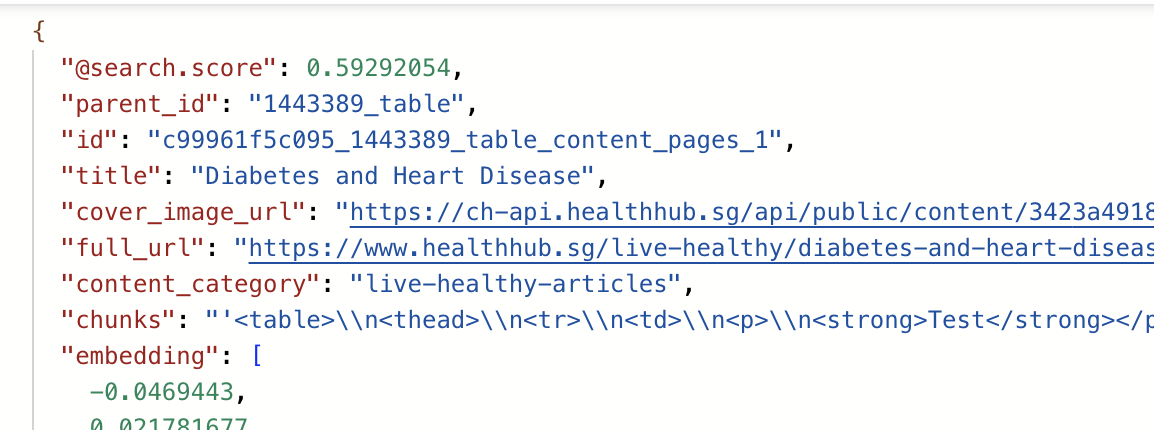

#### Sample Search:
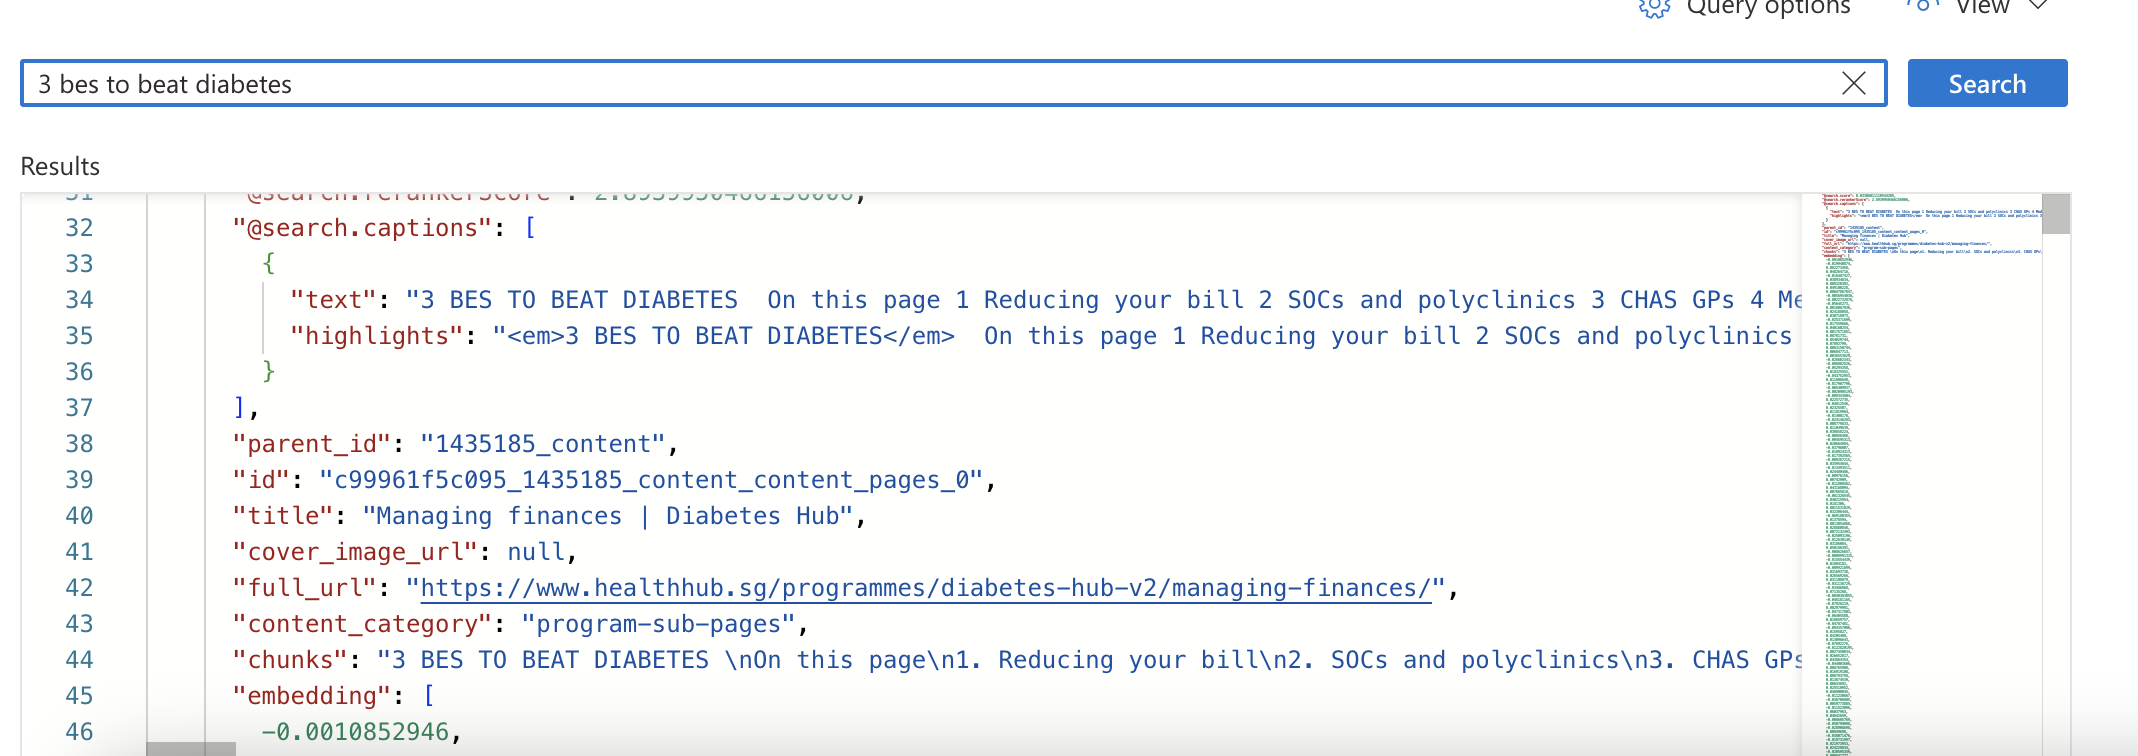